## Accuracy as a function taxon evenness & % atom 13C

### Variable parameters:

* Partition communities into 'dominant' and 'rare' subsets
  * __dominant/rare cutoff: 1% relative abundance?__
* Assess sensitivity & specificity for each subset
* __Note:__ 
  * Much less time to perform if using data from past simulation run datasets

### Analysis:

* Sup Figures:
  * Same as above simulation runs, but split into 'dominant' vs 'rare'

# User variables

In [1]:
workDir = '/home/nick/notebook/SIPSim/dev/bac_genome1210/'
sourceDir = os.path.join(workDir, 'atomIncorp_evenness')
buildDir = os.path.join(workDir, 'atomIncorp_evenness_abund')
R_dir = '/home/nick/notebook/SIPSim/lib/R/'

# Init

In [2]:
import glob
from os.path import abspath
import nestly
from IPython.display import Image, display

In [3]:
%load_ext rpy2.ipython

In [4]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: grid


In [5]:
if not os.path.isdir(buildDir):
    os.makedirs(buildDir)

# Nestly

In [10]:
# building tree structure
nest = nestly.Nest()

## varying params
#-- full run --#
#nest.add('percIncorp', [0, 25, 50, 100])
#nest.add('percTaxa', [1, 5, 10, 25, 50])
#nest.add('rep', range(1,21))

#-- full run --#
nest.add('abund_dist_p', ['mean:10,sigma:1','mean:10,sigma:2','mean:10,sigma:3'])
nest.add('percIncorp', [0,5,10,15,20,30,40,50,75,100])
nest.add('rep', range(1,21))


## set params
nest.add('percTaxa', [10], create_dir=False)
nest.add('np', [6], create_dir=False)
nest.add('abs', ['1e9'], create_dir=False)
nest.add('subsample_mean', [30000], create_dir=False) 
nest.add('subsample_scale', [5000], create_dir=False) 
nest.add('BD_min', [1.71], create_dir=False)
nest.add('BD_max', [1.75], create_dir=False)
nest.add('padj', [0.1], create_dir=False)
nest.add('log2', [0.25], create_dir=False)
nest.add('topTaxaToPlot', [100], create_dir=False)

## input/output files
nest.add('buildDir', [buildDir], create_dir=False)
nest.add('sourceDir', [sourceDir], create_dir=False)
nest.add('frag_file', ['ampFrags_kde_dif'], create_dir=False)
nest.add('comm_file', ['comm.txt'], create_dir=False)
nest.add('R_dir', [R_dir], create_dir=False)

# building directory tree
nest.build(buildDir)

In [11]:
bashFile = os.path.join(buildDir, 'SIPSimRun.sh')

In [12]:
%%writefile $bashFile
#!/bin/bash

export PATH={R_dir}:$PATH

# copying DESeq files
cp {sourceDir}/{abund_dist_p}/{percIncorp}/{rep}/{comm_file} .
cp {sourceDir}/{abund_dist_p}/{percIncorp}/{rep}/OTU_n2_abs{abs}_sub-norm_DESeq2 .
cp {sourceDir}/{abund_dist_p}/{percIncorp}/{rep}/{frag_file}_incorp_BD-shift.txt .

## DESeq2
DESeq2_rare-dominant.r \
    OTU_n2_abs{abs}_sub-norm_DESeq2 \
    {comm_file} \
    -o OTU_n2_abs{abs}_sub-norm_DESeq2
    
## Confusion matrix
### dominant
DESeq2_confuseMtx.r \
    {frag_file}_incorp_BD-shift.txt \
    OTU_n2_abs{abs}_sub-norm_DESeq2_dom \
    --padj {padj} \
    -o DESeq2-cMtx_dom
### rare    
DESeq2_confuseMtx.r \
    {frag_file}_incorp_BD-shift.txt \
    OTU_n2_abs{abs}_sub-norm_DESeq2_rare \
    --padj {padj} \
    -o DESeq2-cMtx_rare

Writing /home/nick/notebook/SIPSim/dev/bac_genome1210/atomIncorp_evenness_abund/SIPSimRun.sh


In [13]:
!chmod 775 $bashFile

In [14]:
!cd $workDir; \
    nestrun -j 20 --template-file $bashFile -d atomIncorp_evenness_abund --log-file log.txt

2015-08-10 11:56:00,214 * INFO * Template: ./SIPSimRun.sh
2015-08-10 11:56:00,217 * INFO * [110517] Started ./SIPSimRun.sh in atomIncorp_evenness_abund/mean:10,sigma:3/20/20
2015-08-10 11:56:00,221 * INFO * [110518] Started ./SIPSimRun.sh in atomIncorp_evenness_abund/mean:10,sigma:3/20/14
2015-08-10 11:56:00,223 * INFO * [110519] Started ./SIPSimRun.sh in atomIncorp_evenness_abund/mean:10,sigma:3/20/7
2015-08-10 11:56:00,227 * INFO * [110520] Started ./SIPSimRun.sh in atomIncorp_evenness_abund/mean:10,sigma:3/20/19
2015-08-10 11:56:00,230 * INFO * [110524] Started ./SIPSimRun.sh in atomIncorp_evenness_abund/mean:10,sigma:3/20/18
2015-08-10 11:56:00,232 * INFO * [110527] Started ./SIPSimRun.sh in atomIncorp_evenness_abund/mean:10,sigma:3/20/15
2015-08-10 11:56:00,236 * INFO * [110528] Started ./SIPSimRun.sh in atomIncorp_evenness_abund/mean:10,sigma:3/20/11
2015-08-10 11:56:00,238 * INFO * [110531] Started ./SIPSimRun.sh in atomIncorp_evenness_abund/mean:10,sigma:3/20/16
2015-08-10 11:5

### Adding DESeq results table of 'NA' if file is not present

In [75]:
p = os.path.join(workDir, 'atomIncorp_evenness_abund', 'mean*/*/*', 'DESeq2-cMtx_rare_byClass.csv')
rareFiles = glob.glob(p)
p = os.path.join(workDir, 'atomIncorp_evenness_abund', 'mean*/*/*', 'DESeq2-cMtx_dom_byClass.csv')
domFiles = glob.glob(p)

print len(rareFiles)
print len(domFiles)

600
580


In [76]:
byClass_tmp = [
['Sensitivity','NA','NA',0,0],
['Specificity','NA','NA',0,0],
['Pos Pred Value','NA','NA',0,0],
['Neg Pred Value','NA','NA',0,0],
['Prevalence','NA','NA',0,0],
['Detection Rate','NA','NA',0,0],
['Detection Prevalence','NA','NA',0,0],
['Balanced Accuracy','NA','NA',0,0]
]

byClass_tmp = pd.DataFrame(byClass_tmp, columns=['','byClass','abund_dist_p','percIncorp','rep'])

In [77]:
# finding files not present
rareFiles = set([x.rstrip('_rare_byClass.csv') for x in rareFiles])
domFiles = set([x.rstrip('_dom_byClass.csv') for x in domFiles])

# in rare but not in dominant list
missingFiles = list(rareFiles - domFiles)

cols = ['abund_dist_p','percIncorp','rep']

for f in missingFiles:    
    df_tmp = byClass_tmp.copy()
    x = f.split('/')
    df_tmp.loc[:,cols] = x[-4:-1]

    outFile = '_'.join([f, 'dom_byClass.csv'])
    df_tmp.to_csv(outFile)

## aggregating confusion matrix data

In [78]:
## byClass
### dominant
!cd $workDir; \
    nestagg delim \
        -d atomIncorp_evenness_abund \
        -k abund_dist_p,percIncorp,rep \
        -o ./atomIncorp_evenness_abund/DESeq2-cMtx_dom_byClass.csv \
        DESeq2-cMtx_dom_byClass.csv

### rare
!cd $workDir; \
    nestagg delim \
        -d atomIncorp_evenness_abund \
        -k abund_dist_p,percIncorp,rep \
        -o ./atomIncorp_evenness_abund/DESeq2-cMtx_rare_byClass.csv \
        DESeq2-cMtx_rare_byClass.csv        

# Plotting accuracy

## Dominant taxa

In [79]:
%%R -i workDir
setwd(workDir)

byClass = read.csv('./atomIncorp_evenness_abund/DESeq2-cMtx_dom_byClass.csv')
byClass %>% head

               X   byClass    abund_dist_p percIncorp rep
1    Sensitivity 0.0000000 mean:10,sigma:3         20  20
2    Specificity 1.0000000 mean:10,sigma:3         20  20
3 Pos Pred Value        NA mean:10,sigma:3         20  20
4 Neg Pred Value 0.7647059 mean:10,sigma:3         20  20
5     Prevalence 0.2352941 mean:10,sigma:3         20  20
6 Detection Rate 0.0000000 mean:10,sigma:3         20  20


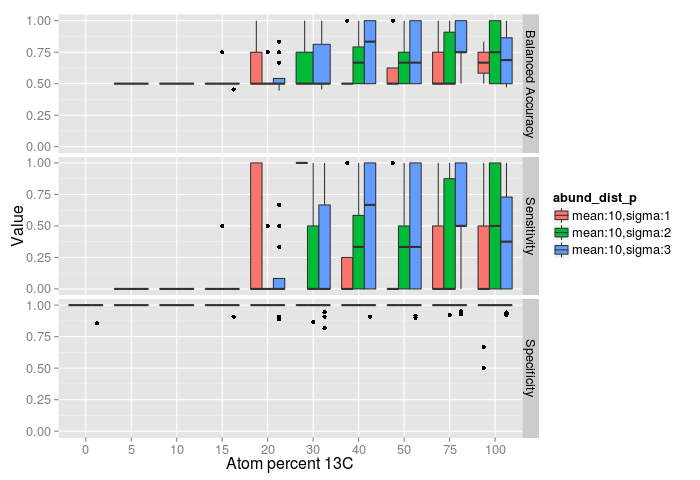

In [81]:
%%R -w 700
to.keep = c('Sensitivity', 'Specificity', 'Balanced Accuracy')

byClass.f = byClass %>%
    filter(X %in% to.keep) %>%
    mutate(percIncorp = as.character(percIncorp))

byClass.f$percIncorp = factor(byClass.f$percIncorp, levels=sort(unique(as.numeric(byClass.f$percIncorp))))

ggplot(byClass.f, aes(percIncorp, byClass, fill=abund_dist_p)) +
    geom_boxplot() +
    labs(y='Value', x='Atom percent 13C') +
    facet_grid(X ~ .) +
        theme(
        text = element_text(size=16)
        )

## Rare taxa

In [82]:
%%R -i workDir
setwd(workDir)

byClass = read.csv('./atomIncorp_evenness_abund/DESeq2-cMtx_rare_byClass.csv')
byClass %>% head

               X     byClass    abund_dist_p percIncorp rep
1    Sensitivity 0.052631579 mean:10,sigma:3         20  20
2    Specificity 1.000000000 mean:10,sigma:3         20  20
3 Pos Pred Value 1.000000000 mean:10,sigma:3         20  20
4 Neg Pred Value 0.904255319 mean:10,sigma:3         20  20
5     Prevalence 0.100529101 mean:10,sigma:3         20  20
6 Detection Rate 0.005291005 mean:10,sigma:3         20  20


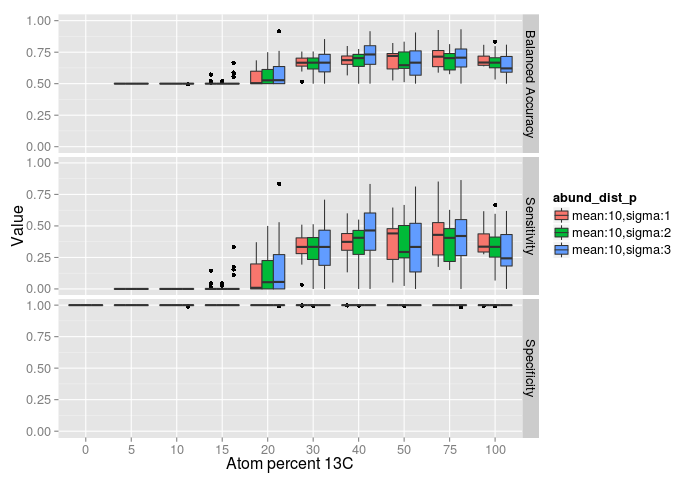

In [83]:
%%R -w 700
to.keep = c('Sensitivity', 'Specificity', 'Balanced Accuracy')

byClass.f = byClass %>%
    filter(X %in% to.keep) %>%
    mutate(percIncorp = as.character(percIncorp))

byClass.f$percIncorp = factor(byClass.f$percIncorp, levels=sort(unique(as.numeric(byClass.f$percIncorp))))

ggplot(byClass.f, aes(percIncorp, byClass, fill=abund_dist_p)) +
    geom_boxplot() +
    labs(y='Value', x='Atom percent 13C') +
    facet_grid(X ~ .) +
        theme(
        text = element_text(size=16)
        )

# Sample size of dominants and rares

* Method:
    * Get number of taxa from dominant/rare-parsed DESeq2 object files

In [84]:
%%R -i workDir
setwd(workDir)

dom.files = grep('DESeq2_dom$', list.files('./atomIncorp_evenness_abund/', recursive=TRUE), value=TRUE)
rare.files = grep('DESeq2_rare$', list.files('./atomIncorp_evenness_abund/', recursive=TRUE), value=TRUE)

read_taxa = function(file.name, dir='atomIncorp_evenness_abund'){
    f = paste(c(dir, file.name), collapse='/')
    deseq.res = readRDS(f)
    n.taxa = length(unique(rownames(deseq.res)))
    return(n.taxa)
    }

dom.taxa = list()
for(f in dom.files){
    dom.taxa[[f]] = read_taxa(f)
    }

rare.taxa = list()
for(f in rare.files){
    rare.taxa[[f]] = read_taxa(f)
    }


In [89]:
%%R 
tbl.dom = as.data.frame(do.call(rbind, dom.taxa))
tbl.dom$abund = 'Dominant'
tbl.rare = as.data.frame(do.call(rbind, rare.taxa))
tbl.rare$abund = 'Rare'

tbl.dom.rare = rbind(tbl.dom, tbl.rare)
colnames(tbl.dom.rare)[1] = 'N.taxa'
tbl.dom.rare$file = rownames(tbl.dom.rare) 
tbl.dom.rare = tbl.dom.rare %>% 
    separate(file, c('abund_dist_p','percIncorp','rep','file'), sep='/') 
tbl.dom.rare %>% head

                                                       N.taxa    abund
mean:10,sigma:1/0/10/OTU_n2_abs1e9_sub-norm_DESeq2_dom      1 Dominant
mean:10,sigma:1/0/11/OTU_n2_abs1e9_sub-norm_DESeq2_dom      3 Dominant
mean:10,sigma:1/0/12/OTU_n2_abs1e9_sub-norm_DESeq2_dom      2 Dominant
mean:10,sigma:1/0/13/OTU_n2_abs1e9_sub-norm_DESeq2_dom      2 Dominant
mean:10,sigma:1/0/14/OTU_n2_abs1e9_sub-norm_DESeq2_dom      1 Dominant
mean:10,sigma:1/0/15/OTU_n2_abs1e9_sub-norm_DESeq2_dom      2 Dominant
                                                          abund_dist_p
mean:10,sigma:1/0/10/OTU_n2_abs1e9_sub-norm_DESeq2_dom mean:10,sigma:1
mean:10,sigma:1/0/11/OTU_n2_abs1e9_sub-norm_DESeq2_dom mean:10,sigma:1
mean:10,sigma:1/0/12/OTU_n2_abs1e9_sub-norm_DESeq2_dom mean:10,sigma:1
mean:10,sigma:1/0/13/OTU_n2_abs1e9_sub-norm_DESeq2_dom mean:10,sigma:1
mean:10,sigma:1/0/14/OTU_n2_abs1e9_sub-norm_DESeq2_dom mean:10,sigma:1
mean:10,sigma:1/0/15/OTU_n2_abs1e9_sub-norm_DESeq2_dom mean:10,sigma:1
      

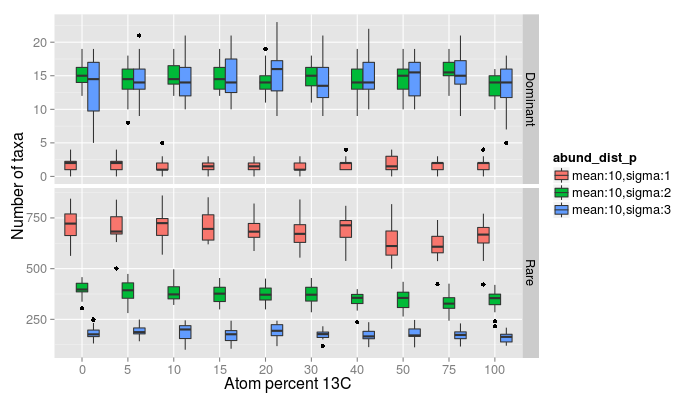

In [90]:
%%R -w 700 -h 400

tbl.dom.rare$percIncorp = factor(tbl.dom.rare$percIncorp, levels=sort(unique(as.numeric(tbl.dom.rare$percIncorp))))
#tbl.dom.rare$abund_dist_p = factor(tbl.dom.rare$abund_dist_p, levels=sort(unique(as.numeric(tbl.dom.rare$abund_dist_p))))

ggplot(tbl.dom.rare, aes(percIncorp, N.taxa, fill=abund_dist_p)) +
    geom_boxplot(position='dodge') +
    labs(y='Number of taxa', x='Atom percent 13C') +
    facet_grid(abund ~ ., scales='free_y') +
    theme(
        text = element_text(size=16)
        )

# Plotting sensitivity ~ taxon_abundance

* Method: 
  * table join: DESeq res file & BD-shift
    * join on taxon
  * use cutoffs to select which taxa 'incorporated'
    * padj < 0.1
  * compare DESeq result to true result
    * TP,FP,TN,FN

* Figure:
  * axes: taxon ~ abundance (pointrange: replicates)
    * ordered by abundance
  * color by classification (TP,FP,TN,FN)
  * facet: percIncorp ~ percTaxa

In [91]:
%%bash -s "$R_dir"

find atomIncorp_evenness_abund/ -name "*DESeq2" | \
    perl -pe 's/(.+\/).+/\1/' | \
    xargs -P 30 -I % bash -c \
    "$1DESeq2_addInfo.r %OTU_n2_abs1e9_sub-norm_DESeq2 %comm.txt %ampFrags_kde_dif_incorp_BD-shift.txt > %OTU_n2_abs1e9_sub-norm_DESeq2_info"
    

In [92]:
%%R -i workDir
setwd(workDir)

deseq.files = grep('_DESeq2_info$', list.files('./atomIncorp_evenness_abund/', recursive=TRUE), value=TRUE)


tbl.l = list()
for(f in deseq.files){
    f = paste(c('./atomIncorp_evenness_abund/', f), collapse='/')
    tbl.l[[f]] = readRDS(f) %>% mutate(file = f)
    }

tbl = do.call(rbind, tbl.l)
rownames(tbl) = seq(1,nrow(tbl))

tbl %>% head

     baseMean log2FoldChange      lfcSE stat    pvalue padj         p padj.BH
1  0.02886831    -0.03323528 0.09890078    0 0.9979073    1 0.9979073       1
2  0.00000000             NA         NA   NA        NA   NA        NA      NA
3  0.00000000             NA         NA   NA        NA   NA        NA      NA
4  7.76686371    -0.16698690 0.28409613    0 0.9289162    1 0.9289162       1
5  6.86091841     0.09419660 0.21309675    0 0.7676530    1 0.7676530       1
6 25.89944652     0.10113597 0.28928469    0 0.6965815    1 0.6965815       1
                                 taxon lib1 lib2 BD_shift mean_rel_abund_perc
1       Acetobacterium_woodii_DSM_1030   NA    2        0          0.03895585
2    Acetohalobium_arabaticum_DSM_5501   NA    2        0          0.01644128
3         Acholeplasma_laidlawii_PG-8A   NA    2        0          0.07311240
4        Achromobacter_xylosoxidans_A8   NA    2        0          0.05935671
5 Acidaminococcus_fermentans_DSM_20731   NA    2        0       

In [99]:
%%R
tbl.e = tbl %>%
    mutate(file = gsub('.+//','', file)) %>%
    separate(file, c('abund_dist_p','percIncorp','rep','file'), sep='/') #%>%
    #unite(percIncorp_percTaxa, percIncorp, percTaxa, sep='_', remove=FALSE)
tbl.e %>% head

     baseMean log2FoldChange      lfcSE stat    pvalue padj         p padj.BH
1  0.02886831    -0.03323528 0.09890078    0 0.9979073    1 0.9979073       1
2  0.00000000             NA         NA   NA        NA   NA        NA      NA
3  0.00000000             NA         NA   NA        NA   NA        NA      NA
4  7.76686371    -0.16698690 0.28409613    0 0.9289162    1 0.9289162       1
5  6.86091841     0.09419660 0.21309675    0 0.7676530    1 0.7676530       1
6 25.89944652     0.10113597 0.28928469    0 0.6965815    1 0.6965815       1
                                 taxon lib1 lib2 BD_shift mean_rel_abund_perc
1       Acetobacterium_woodii_DSM_1030   NA    2        0          0.03895585
2    Acetohalobium_arabaticum_DSM_5501   NA    2        0          0.01644128
3         Acholeplasma_laidlawii_PG-8A   NA    2        0          0.07311240
4        Achromobacter_xylosoxidans_A8   NA    2        0          0.05935671
5 Acidaminococcus_fermentans_DSM_20731   NA    2        0       

In [100]:
%%R
BD.shift.cut = 0.05
padj.cut = 0.1


clsfy = function(guess,known){
    if(is.na(guess) | is.na(known)){
        return(NA)
        }
    if(guess == TRUE){
        if(guess == known){
            return('TP')
            } else {
            return('FP')
            }
        } else
    if(guess == FALSE){
        if(guess == known){
            return('TN')
            } else {
            return('FN')
            }
        } else {
        stop('Error: true or false needed')
        }
    }

tbl.e = tbl.e %>% 
    mutate(true_incorp = BD_shift > BD.shift.cut,
           DESeq_incorp = padj < padj.cut,
           cls = mapply(clsfy, DESeq_incorp, true_incorp)) 
    
tbl.e %>% head    

     baseMean log2FoldChange      lfcSE stat    pvalue padj         p padj.BH
1  0.02886831    -0.03323528 0.09890078    0 0.9979073    1 0.9979073       1
2  0.00000000             NA         NA   NA        NA   NA        NA      NA
3  0.00000000             NA         NA   NA        NA   NA        NA      NA
4  7.76686371    -0.16698690 0.28409613    0 0.9289162    1 0.9289162       1
5  6.86091841     0.09419660 0.21309675    0 0.7676530    1 0.7676530       1
6 25.89944652     0.10113597 0.28928469    0 0.6965815    1 0.6965815       1
                                 taxon lib1 lib2 BD_shift mean_rel_abund_perc
1       Acetobacterium_woodii_DSM_1030   NA    2        0          0.03895585
2    Acetohalobium_arabaticum_DSM_5501   NA    2        0          0.01644128
3         Acholeplasma_laidlawii_PG-8A   NA    2        0          0.07311240
4        Achromobacter_xylosoxidans_A8   NA    2        0          0.05935671
5 Acidaminococcus_fermentans_DSM_20731   NA    2        0       

In [101]:
%%R
tbl.e$taxon = reorder(tbl.e$taxon, dense_rank(tbl.e$mean_rel_abund_perc))
tbl.e$percIncorp = factor(tbl.e$percIncorp, levels=sort(unique(as.numeric(tbl.e$percIncorp))))
#tbl.e$percTaxa = factor(tbl.e$percTaxa, levels=sort(unique(as.numeric(tbl.e$percTaxa))))

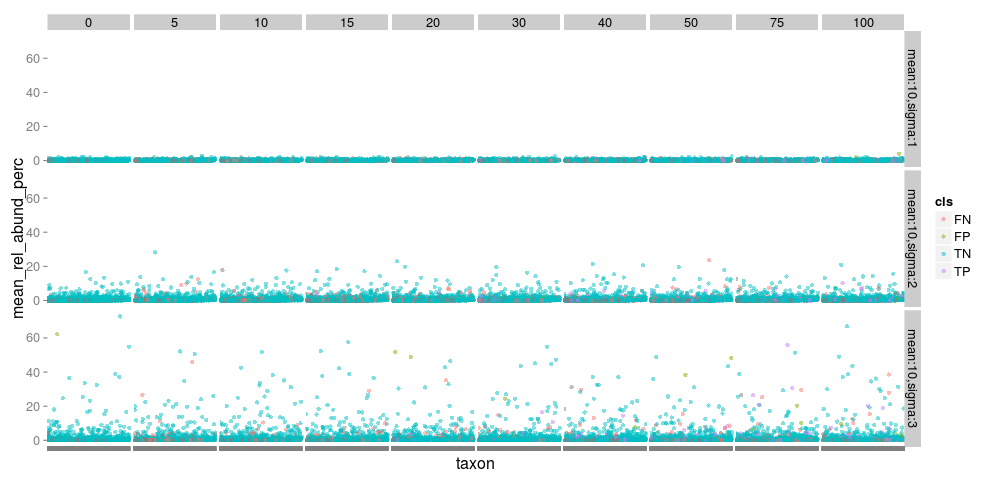

In [105]:
%%R -w 1000

ggplot(tbl.e, aes(taxon, mean_rel_abund_perc, color=cls)) +
    geom_point(alpha=0.5) +
    facet_grid(abund_dist_p ~ percIncorp) +
    theme(
        text = element_text(size=16),
        axis.text.x = element_blank()
        )

In [108]:
%%R

clsfy = function(guess,known){
    if(is.na(guess) | is.na(known)){
        return(NA)
        }
    if(guess == TRUE){
        if(guess == known){
            return(1)
            } else {
            return(NA)
            }
        } else
    if(guess == FALSE){
        if(guess == known){
            return(NA)
            } else {
            return(0)
            }
        } else {
        stop('Error: true or false needed')
        }
    }

tbl.s.c = tbl.e %>%
    mutate(TP_FN = mapply(clsfy, DESeq_incorp, true_incorp)) %>%
    filter(! is.na(TP_FN)) %>%
    group_by(percIncorp, abund_dist_p) %>%
    summarize(cor.pearson = cor(mean_rel_abund_perc, TP_FN))

tbl.s.c %>% head

Source: local data frame [6 x 3]
Groups: percIncorp

  percIncorp    abund_dist_p cor.pearson
1          5 mean:10,sigma:1          NA
2          5 mean:10,sigma:2          NA
3          5 mean:10,sigma:3          NA
4         10 mean:10,sigma:1          NA
5         10 mean:10,sigma:2          NA
6         10 mean:10,sigma:3          NA


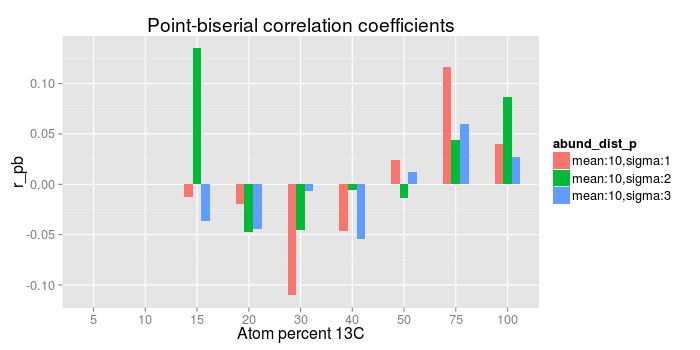

In [110]:
%%R -w 700 -h 350
ggplot(tbl.s.c, aes(percIncorp, cor.pearson, fill=abund_dist_p)) +
    geom_bar(stat='identity', position='dodge', width=0.5) +
    labs(x='Atom percent 13C', y='r_pb', title='Point-biserial correlation coefficients') +
    theme(
        text = element_text(size=16)
        )

__Notes:__



***

# SANDBOX

In [170]:
%%R -i workDir
setwd(workDir)

x.deseq = './validation/OTU_n2_abs1e10_sub20000_DESeq2'
deseq.res = readRDS(x.deseq)
deseq.res = as.data.frame(deseq.res)
deseq.res$taxon = rownames(deseq.res)
deseq.res %>% head

                                    baseMean log2FoldChange    lfcSE      stat
Acetohalobium_arabaticum_DSM_5501  0.4745836      0.9200834 1.394946 0.4803651
Acidovorax_citrulli_AAC00-1        3.2902741     -4.6553395 1.275818 0.0000000
Acidovorax_ebreus_TPSY             4.8031896     -1.0010777 1.176846 0.0000000
Aeromonas_hydrophila_AL09-71       0.7088409      0.5138864 1.270017 0.2077818
Alkalilimnicola_ehrlichii_MLHE-1  28.0436962     -1.2126332 1.274566 0.0000000
Alkaliphilus_oremlandii_OhILAs    29.5094790      0.5352219 1.697529 0.1680218
                                     pvalue padj         p padj.BH
Acetohalobium_arabaticum_DSM_5501 0.3154839    1 0.3154839       1
Acidovorax_citrulli_AAC00-1       0.9999397    1 0.9999397       1
Acidovorax_ebreus_TPSY            0.8561264    1 0.8561264       1
Aeromonas_hydrophila_AL09-71      0.4176997    1 0.4176997       1
Alkalilimnicola_ehrlichii_MLHE-1  0.8744236    1 0.8744236       1
Alkaliphilus_oremlandii_OhILAs    0.4332831  

In [171]:
%%R -i workDir
setwd(workDir) 

x.comm = 'validation/comm.txt'
comm = read.delim(x.comm, sep='\t')
comm.s = comm %>%
    group_by(taxon_name) %>%
    summarize(mean_rel_abund_perc = mean(rel_abund_perc)) %>%
    mutate(rank = dense_rank(mean_rel_abund_perc))
comm.s %>% head 

Source: local data frame [6 x 3]

                            taxon_name mean_rel_abund_perc rank
1       Acaryochloris_marina_MBIC11017         0.089773401 1010
2       Acetobacterium_woodii_DSM_1030         0.013390418  609
3 Acetobacter_pasteurianus_IFO_3283-12         0.003064792  270
4    Acetohalobium_arabaticum_DSM_5501         0.058114601  928
5         Acholeplasma_laidlawii_PG-8A         0.004121299  323
6        Achromobacter_xylosoxidans_A8         0.024560238  752


In [172]:
%%R -i workDir
setwd(workDir) 

x.BD = 'validation/ampFrags_kde_dif_incorp_BD-shift.txt'
BD.shift = read.delim(x.BD, sep='\t')
BD.shift = BD.shift %>% 
    filter(lib2 == 2)
BD.shift %>% head 

  lib1 lib2                              taxon BD_shift
1   NA    2         Vibrio_vulnificus_MO6-24_O        0
2   NA    2        Caldisericum_exile_AZM16c01      NaN
3   NA    2        Spiroplasma_taiwanense_CT-1        0
4   NA    2 Thermoanaerobacter_wiegelii_Rt8_B1        0
5   NA    2       Anabaena_cylindrica_PCC_7122        0
6   NA    2    Haemophilus_parainfluenzae_T3T1        0


In [173]:
%%R

tbl.j = inner_join(deseq.res, BD.shift, c('taxon' = 'taxon'))
tbl.j = inner_join(tbl.j, comm.s, c('taxon' = 'taxon_name'))
tbl.j %>% head

    baseMean log2FoldChange    lfcSE      stat    pvalue padj         p padj.BH
1  0.4745836      0.9200834 1.394946 0.4803651 0.3154839    1 0.3154839       1
2  3.2902741     -4.6553395 1.275818 0.0000000 0.9999397    1 0.9999397       1
3  4.8031896     -1.0010777 1.176846 0.0000000 0.8561264    1 0.8561264       1
4  0.7088409      0.5138864 1.270017 0.2077818 0.4176997    1 0.4176997       1
5 28.0436962     -1.2126332 1.274566 0.0000000 0.8744236    1 0.8744236       1
6 29.5094790      0.5352219 1.697529 0.1680218 0.4332831    1 0.4332831       1
                              taxon lib1 lib2  BD_shift mean_rel_abund_perc
1 Acetohalobium_arabaticum_DSM_5501   NA    2 0.0000000          0.05811460
2       Acidovorax_citrulli_AAC00-1   NA    2 0.9994683          0.07152763
3            Acidovorax_ebreus_TPSY   NA    2 0.0000000          0.14267760
4      Aeromonas_hydrophila_AL09-71   NA    2 0.9968581          0.02364744
5  Alkalilimnicola_ehrlichii_MLHE-1   NA    2 0.0000000     

In [174]:
%%R
BD.shift.cut = 0.05
padj.cut = 0.1


clsfy = function(guess,known){
    if(guess == TRUE){
        if(guess == known){
            return('TP')
            } else {
            return('FP')
            }
        } else
    if(guess == FALSE){
        if(guess == known){
            return('TN')
            } else {
            return('FN')
            }
        } else {
        stop('Error: true or false needed')
        }
    }

tbl.j = tbl.j %>% 
    mutate(true_incorp = BD_shift > BD.shift.cut,
           DESeq_incorp = padj < padj.cut,
           cls = mapply(clsfy, DESeq_incorp, true_incorp)) 
    
tbl.j %>% head    

    baseMean log2FoldChange    lfcSE      stat    pvalue padj         p padj.BH
1  0.4745836      0.9200834 1.394946 0.4803651 0.3154839    1 0.3154839       1
2  3.2902741     -4.6553395 1.275818 0.0000000 0.9999397    1 0.9999397       1
3  4.8031896     -1.0010777 1.176846 0.0000000 0.8561264    1 0.8561264       1
4  0.7088409      0.5138864 1.270017 0.2077818 0.4176997    1 0.4176997       1
5 28.0436962     -1.2126332 1.274566 0.0000000 0.8744236    1 0.8744236       1
6 29.5094790      0.5352219 1.697529 0.1680218 0.4332831    1 0.4332831       1
                              taxon lib1 lib2  BD_shift mean_rel_abund_perc
1 Acetohalobium_arabaticum_DSM_5501   NA    2 0.0000000          0.05811460
2       Acidovorax_citrulli_AAC00-1   NA    2 0.9994683          0.07152763
3            Acidovorax_ebreus_TPSY   NA    2 0.0000000          0.14267760
4      Aeromonas_hydrophila_AL09-71   NA    2 0.9968581          0.02364744
5  Alkalilimnicola_ehrlichii_MLHE-1   NA    2 0.0000000     

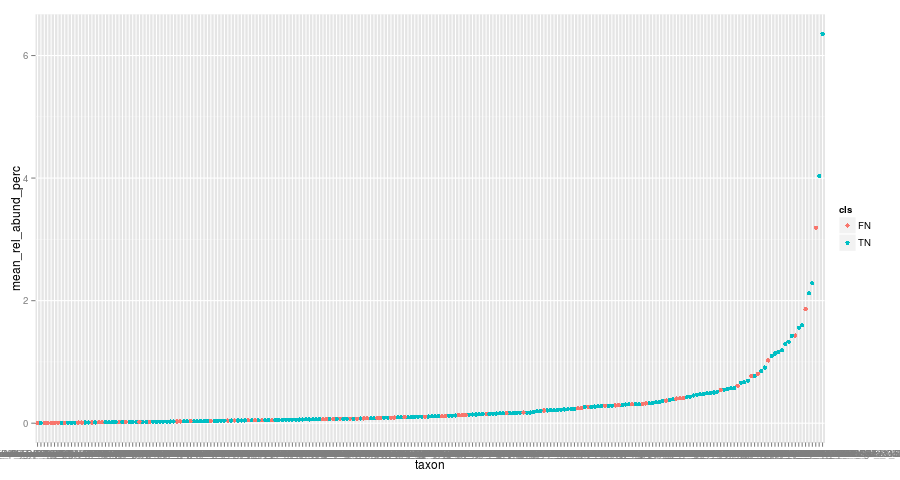

In [175]:
%%R -w 900

tbl.j$taxon = reorder(tbl.j$taxon, tbl.j$mean_rel_abund_perc)

ggplot(tbl.j, aes(taxon, mean_rel_abund_perc, color=cls)) +
    geom_point()

***

In [ ]:
%%R -i workDir
setwd(workDir)

deseq.res = readRDS('./validation/OTU_n2_abs1e10_sub20000_DESeq2')

In [17]:
%%R

comm = read.delim('./validation/comm.txt', sep='\t')
comm.s = comm %>%
    group_by(taxon_name) %>%
    summarize(mean_rel_abund_perc = mean(rel_abund_perc))
comm.s %>% head

Source: local data frame [6 x 2]

                            taxon_name mean_rel_abund_perc
1       Acaryochloris_marina_MBIC11017         0.089773401
2       Acetobacterium_woodii_DSM_1030         0.013390418
3 Acetobacter_pasteurianus_IFO_3283-12         0.003064792
4    Acetohalobium_arabaticum_DSM_5501         0.058114601
5         Acholeplasma_laidlawii_PG-8A         0.004121299
6        Achromobacter_xylosoxidans_A8         0.024560238


In [21]:
%%R
tmp = deseq.res %>%
    as.data.frame() 
tmp$taxon_name = rownames(tmp)

tmp = inner_join(tmp, comm.s, c('taxon_name' = 'taxon_name'))
tmp = tmp %>%
    mutate(dom_rare = mean_rel_abund_perc > 1)

tmp %>% head

    baseMean log2FoldChange    lfcSE      stat    pvalue padj         p padj.BH
1  0.4745836      0.9200834 1.394946 0.4803651 0.3154839    1 0.3154839       1
2  3.2902741     -4.6553395 1.275818 0.0000000 0.9999397    1 0.9999397       1
3  4.8031896     -1.0010777 1.176846 0.0000000 0.8561264    1 0.8561264       1
4  0.7088409      0.5138864 1.270017 0.2077818 0.4176997    1 0.4176997       1
5 28.0436962     -1.2126332 1.274566 0.0000000 0.8744236    1 0.8744236       1
6 29.5094790      0.5352219 1.697529 0.1680218 0.4332831    1 0.4332831       1
                         taxon_name mean_rel_abund_perc dom_rare
1 Acetohalobium_arabaticum_DSM_5501          0.05811460    FALSE
2       Acidovorax_citrulli_AAC00-1          0.07152763    FALSE
3            Acidovorax_ebreus_TPSY          0.14267760    FALSE
4      Aeromonas_hydrophila_AL09-71          0.02364744    FALSE
5  Alkalilimnicola_ehrlichii_MLHE-1          0.77596664    FALSE
6    Alkaliphilus_oremlandii_OhILAs          1.292

In [22]:
%%R
tmp %>% filter(dom_rare == FALSE) %>% nrow %>% print
tmp %>% filter(dom_rare == TRUE) %>% nrow %>% print

[1] 215
[1] 17
